In [ ]:
#@title Instalação de Bibliotecas e Dataset:

!pip install kagglehub
!pip install scikit-learn pandas numpy matplotlib seaborn

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Pré-processamento
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Algoritmos de Regressão
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge


# Métricas
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Reprodutibilidade
RANDOM_STATE = 42

print("Bibliotecas carregadas com sucesso.")

# O arquivo CSV neste dataset é 'StudentPerformanceFactors.csv'
file_path = "StudentPerformanceFactors.csv"
try:
    df_raw = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        "anassarfraz13/student-success-factors-and-insights",
        file_path,
    )
    print("\nDataset carregado com sucesso.")
    print(f"Total de registros: {len(df_raw)}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")

Bibliotecas carregadas com sucesso.
Using Colab cache for faster access to the 'student-success-factors-and-insights' dataset.

Dataset carregado com sucesso.
Total de registros: 6607


Informações iniciais do DataFrame (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  P

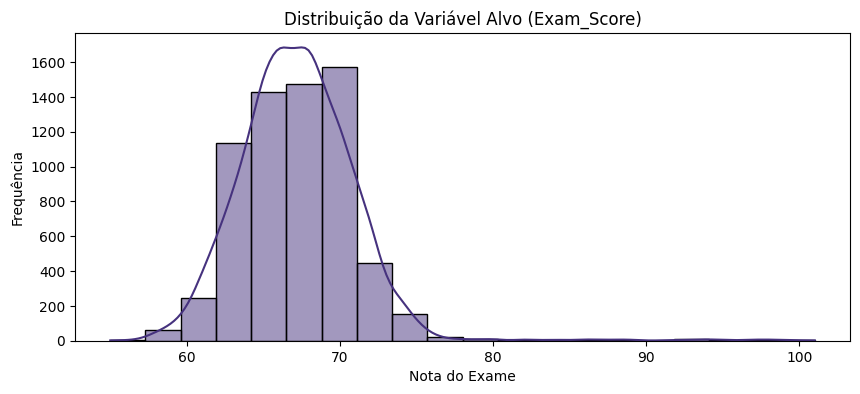


Anomalia tratada: 1 linhas com 'Exam_Score' > 100 foram removidas.
Total de registros após o tratamento de anomalias: 6606

Features numéricas identificadas: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']


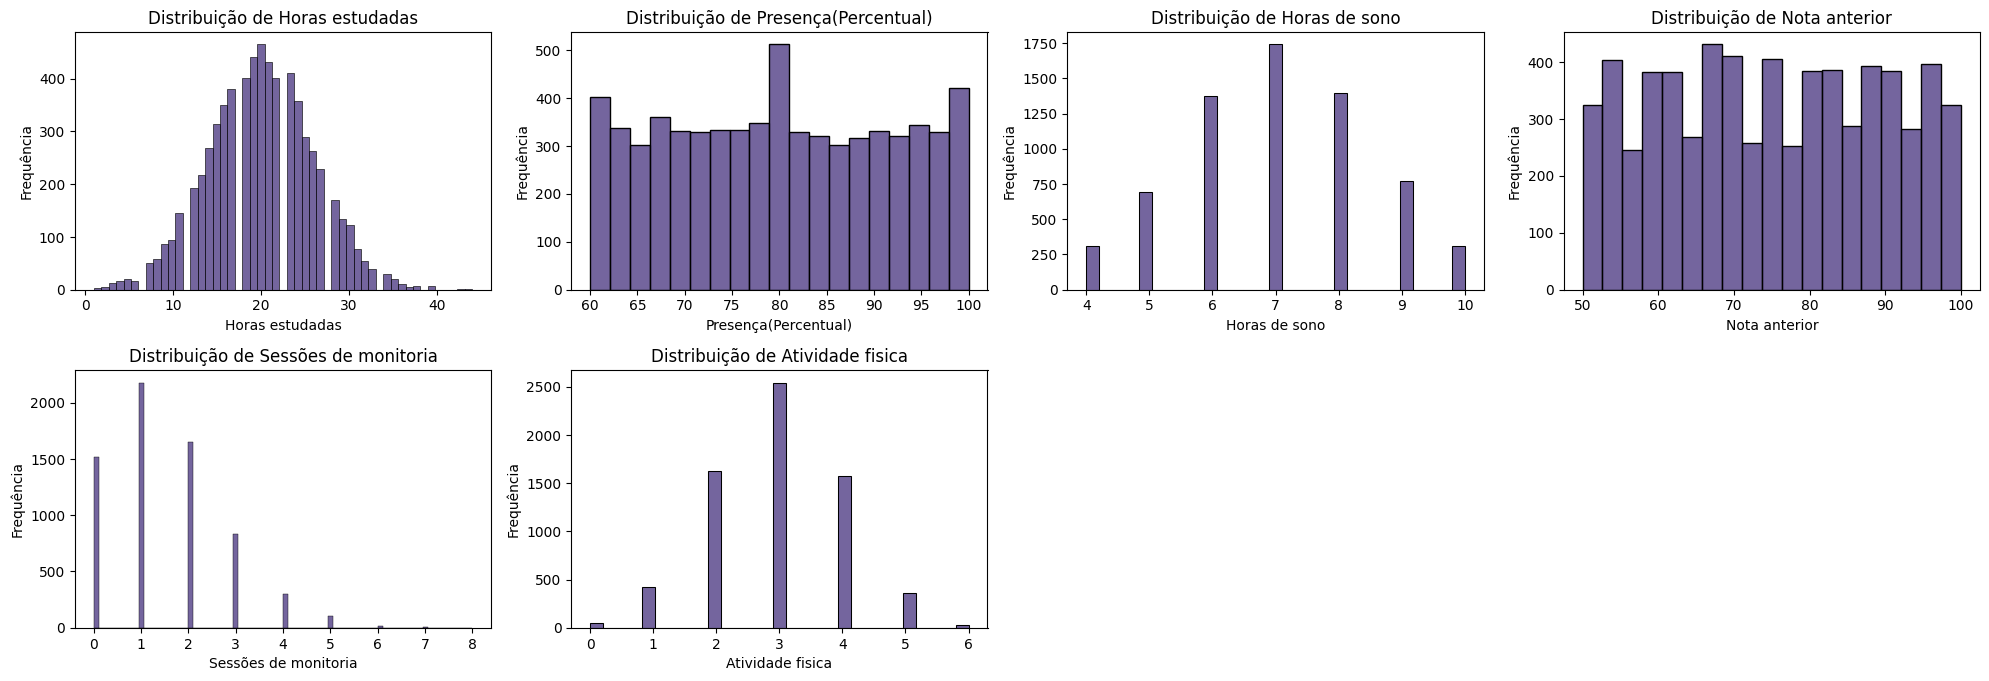

Features categóricas nominais identificadas: ['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Learning_Disabilities', 'Gender']


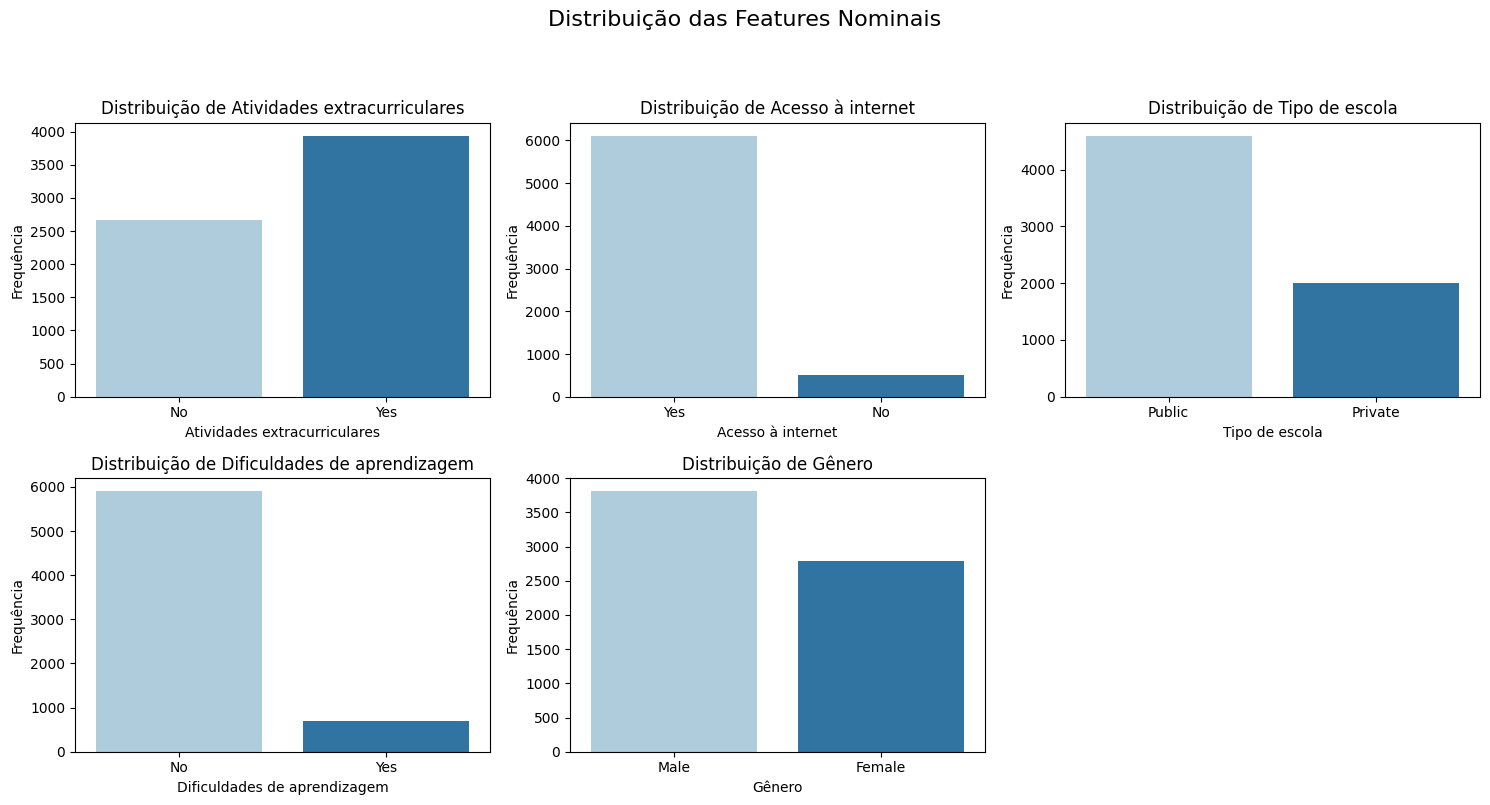

Features categóricas ordinais identificadas: ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality', 'Peer_Influence', 'Parental_Education_Level', 'Distance_from_Home']


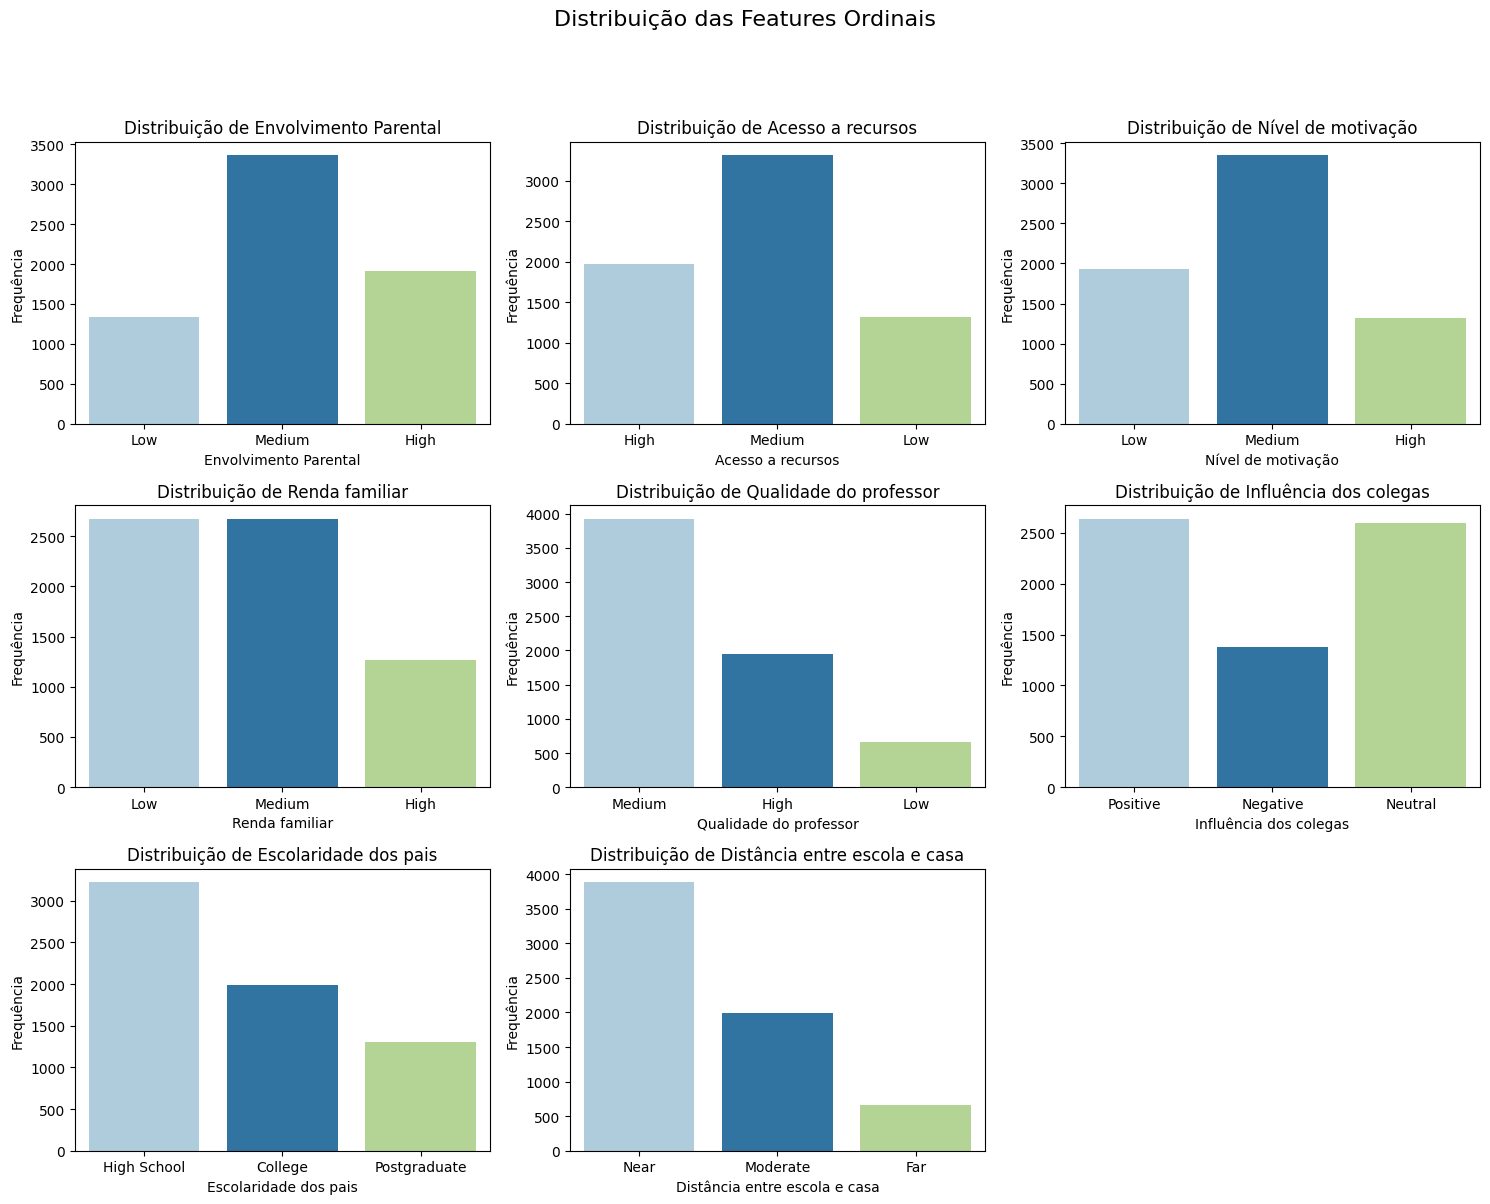

In [ ]:
#@title Análise Exploratória dos Dados (EDA)
if 'df_raw' in locals():
    print("Informações iniciais do DataFrame (df.info()):")
    df_raw.info()

    print("\nSumário estatístico dos atributos numéricos (df.describe()):")
    print(df_raw.describe())

    print("\nVerificação de valores faltantes (df.isnull().sum()):")
    print(df_raw.isnull().sum())

    # EDA da variável alvo: 'Exam_Score'
    plt.figure(figsize=(10, 4))
    sns.histplot(df_raw['Exam_Score'], kde=True, bins=20)
    plt.title('Distribuição da Variável Alvo (Exam_Score)')
    plt.xlabel('Nota do Exame')
    plt.ylabel('Frequência')
    plt.show()






    # Removendo instâncias onde 'Exam_Score' é maior que 100
    initial_rows = len(df_raw)
    df_raw = df_raw[df_raw['Exam_Score'] <= 100]
    removed_rows = initial_rows - len(df_raw)
    if removed_rows > 0:
        print(f"\nAnomalia tratada: {removed_rows} linhas com 'Exam_Score' > 100 foram removidas.")
        print(f"Total de registros após o tratamento de anomalias: {len(df_raw)}")
    else:
        print("\nNenhuma anomalia de 'Exam_Score' > 100 encontrada e removida.")

    # A variável alvo é 'Exam_Score'
    y = df_raw['Exam_Score']

    # As features são todas as outras colunas
    X = df_raw.drop('Exam_Score', axis=1)

    # Identificação dos tipos de atributos para o pré-processamento
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    #categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    # Atributos categoricos devem estar separados em nominais e ordinais
    nominal_features = ['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Learning_Disabilities', 'Gender']
    ordinal_features = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income',
                    'Teacher_Quality', 'Peer_Influence', 'Parental_Education_Level', 'Distance_from_Home']

    print(f"\nFeatures numéricas identificadas: {numeric_features}")

    labels_numeric_features = ['Horas estudadas','Presença(Percentual)','Horas de sono','Nota anterior','Sessões de monitoria','Atividade fisica']

    # EDA dos outros atributos
    plt.figure(figsize=(20, 20))
    for i,attr in enumerate(numeric_features):
        plt.subplot(6,4,i+1)
        #sns.histplot(df_raw[attr], kde=True, bins=40,legend=False)
        sns.histplot(data=df_raw,x=attr,legend=False)
        plt.title(f'Distribuição de {labels_numeric_features[i]}')
        plt.xlabel(labels_numeric_features[i])
        plt.ylabel('Frequência')
    plt.tight_layout()
    plt.show()

    labels_categoric_features = {
        'Parental_Involvement': 'Envolvimento Parental',
        'Access_to_Resources': 'Acesso a recursos',
        'Extracurricular_Activities': 'Atividades extracurriculares',
        'Motivation_Level': 'Nível de motivação',
        'Internet_Access': 'Acesso à internet',
        'Family_Income': 'Renda familiar',
        'Teacher_Quality': 'Qualidade do professor',
        'School_Type': 'Tipo de escola',
        'Peer_Influence': 'Influência dos colegas',
        'Learning_Disabilities': 'Dificuldades de aprendizagem',
        'Parental_Education_Level': 'Escolaridade dos pais',
        'Distance_from_Home': 'Distância entre escola e casa',
        'Gender': 'Gênero'
    }

    print(f"Features categóricas nominais identificadas: {nominal_features}")
    n_cols = 3
    # Calcula o número de linhas necessárias
    n_rows_nom = math.ceil(len(nominal_features) / n_cols)

    plt.figure(figsize=(15, 4 * n_rows_nom))
    plt.suptitle("Distribuição das Features Nominais", fontsize=16, y=1.03)

    for i, attr in enumerate(nominal_features):
        plt.subplot(n_rows_nom, n_cols, i + 1)

        label = labels_categoric_features.get(attr, attr) # Pega o rótulo do dicionário

        sns.countplot(data=df_raw, x=attr, palette="Paired", hue=attr, legend=False)
        plt.title(f'Distribuição de {label}')
        plt.xlabel(label)
        plt.ylabel("Frequência")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajusta layout para o super-título
    plt.show()

    print(f"Features categóricas ordinais identificadas: {ordinal_features}")
    n_rows_ord = math.ceil(len(ordinal_features) / n_cols)

    plt.figure(figsize=(15, 4 * n_rows_ord))
    plt.suptitle("Distribuição das Features Ordinais", fontsize=16, y=1.03)

    for i, attr in enumerate(ordinal_features):
        plt.subplot(n_rows_ord, n_cols, i + 1)

        label = labels_categoric_features.get(attr, attr)

        sns.countplot(data=df_raw, x=attr, palette="Paired", hue=attr, legend=False)
        plt.title(f'Distribuição de {label}')
        plt.xlabel(label)
        plt.ylabel("Frequência")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Ajusta layout para o super-título
    plt.show()
    """
    labels_categoricos = ['Envolvimento Parental','Acesso a recursos','Atividades extracurriculares','Nível de motivação','Acesso à internet','Renda familiar','Qualidade do professor',
                          'Tipo de escola','Influência dos colegas','Dificuldades de aprendizagem','Escolaridade dos pais','Distância entre escola e casa','Gênero']
    plt.figure(figsize=(20, 20))
    for i,attr in enumerate(categorical_features):
        plt.subplot(6,4,i+1)
        sns.countplot(data=df_raw, x=attr, palette="Paired",hue=attr,legend=False)
        plt.title(f'Distribuição de {labels_categoricos[i]}')
        plt.xlabel("Frequencia")
        plt.ylabel(labels_categoricos[i])

    plt.tight_layout()
    plt.show()"""





O conjunto de dados contém 6607 instâncias e 20 atributos, sendo 19 *feautures* preditivas e 1 alvo, "Exam_Score". Assim, entendemos que o estudo foi feito com 6607 alunos e buscava encontrar relações (regressão) entre um conjunto de características demográficas, socioeconômicas e de hábitos de estudo com as notas em um exame.

Entre os atributos, temos:
*   7 atributos numéricos: Horas estudadas, Frequência, Horas de sono, Notas anteriores, Sessões de monitoria, Atividade física e o alvo, Notas do exame.
*   13 atributos categóricos: Envolvimento Parental, Acesso aos recursos, Atividades extracurriculares, Nível de motivação, Acesso à Internet, Renda familiar, Qualidade do professor, Tipo de escola, Influência de amigos, Dificuldades de aprendizado, Nível de estudo dos pais, Distância entre escola e casa e Gênero.

[adicionar parágrafo sobre nominais e ordinais]

Algumas categorias possuem valores faltantes: "Parental_Education_Level", com 90 valores; "Teacher_Quality", com 78 valores; e "Distance_from_Home", com 67 valores. Além disso, todos os atributos categóricos precisarão ser convertidos para um formato numérico. Já os valores numéricos precisarão ser normalizados, uma vez que possuem escalas muito distintas (por exemplo, "Previous_Scores" varia de 50 a 100, e levaria um peso muito maior que um atributo como "Tutoring_Sessions", que varia de 0 a 8).

A respeito do atributo alvo, encontramos uma média de 67.23, com mediana de 67. O desvio padrão é baixo (3.89), indicando valores altamente concentrados, com 50% dos resultados entre 65 e 69. No entanto, uma anomalia é encontrada no valor máximo registrado, de 101, provavelemnte um erro na entrada de dados que deve ser tratado para não enviesar as métricas de avaliação do modelo (principalmente em modleos como RMSE)

***

## Estratégia de Pré-processamento
*   Dados Faltantes: utilizaremos a estratégia de imputação pela moda (o valor mais frequente)
*   Normalização: todas as features numéricas serão normalizadas usando *StandardScaler*, que subtrai a média e divide pelo desvio padrão.
*   Codificação: todas as features categóricas serão transformadas usando OneHotEncoder.
*   Anomalias: instâncias onde *Exam_Score > 100* serão removidas do conjunto. **Eu não tenho certeza se essa é a melhor estratégia pra lidar com anomalias, mas foi o que a internet sugeriu...** De qualquer forma, foi removida acima.



In [ ]:
#@title Pré-processamento dos dados

# Normaliza os dados (média 0, desvio padrão 1).
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)
# SimpleImputer: Preenche os valores faltantes com a moda.
# OneHotEncoder: Converte categorias em colunas binárias.
#    'handle_unknown='ignore'' garante que o modelo não falhe se
#    encontrar uma categoria nova na validação.
map_low_medium_high = ['Low', 'Medium', 'High']
map_peer_influence = ['Negative', 'Neutral', 'Positive']
map_education = ['High School', 'College', 'Postgraduate']
map_distance = ['Near', 'Moderate', 'Far']
nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[
        map_low_medium_high,  # Parental_Involvement
        map_low_medium_high,  # Access_to_Resources (verificar ordem)
        map_low_medium_high,  # Motivation_Level
        map_low_medium_high,  # Family_Income
        map_low_medium_high,  # Teacher_Quality (verificar ordem)
        map_peer_influence,   # Peer_Influence
        map_education,        # Parental_Education_Level
        map_distance          # Distance_from_Home
    ]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (é esperado que não seja usado)
)

print("\nPipeline de pré-processamento definido com sucesso.")


Pipeline de pré-processamento definido com sucesso.


In [ ]:
#@title Definição da Abordagem, Algoritmos e Estratégia de Avaliação

models = {
    'LinearRegression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'SVR': SVR(), # opcional
    'LinearSVR': LinearSVR(random_state=RANDOM_STATE), #OPCIONAL
    'KernelRidge': KernelRidge() #OPCIONAL
}
print(f"\nAlgoritmos selecionados ({len(models)}): {list(models.keys())}")

# K-Fold Cross-Validation Repetido
N_SPLITS = 10
N_REPEATS = 3
cv_strategy = RepeatedKFold(
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    #shuffle=True,
    random_state=RANDOM_STATE)
print(f"\nEstratégia de Avaliação: Repeated K-Fold Cross-Validation com k={N_SPLITS} e n={N_REPEATS}.")

# RMSE como métrica principal e R² como secundária
PRIMARY_METRIC = 'neg_root_mean_squared_error'
SECONDARY_METRIC = 'r2'
print(f"Métrica Principal: RMSE (via '{PRIMARY_METRIC}')")
print(f"Métrica Secundária: R² (via '{SECONDARY_METRIC}')")


Algoritmos selecionados (8): ['LinearRegression', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'SVR', 'LinearSVR', 'KernelRidge']

Estratégia de Avaliação: Repeated K-Fold Cross-Validation com k=10 e n=3.
Métrica Principal: RMSE (via 'neg_root_mean_squared_error')
Métrica Secundária: R² (via 'r2')


## Abordagem: Regressão
A variável alvo 'Exam_Score' é naturalmente quantitativa contínua, representando uma nota".

A ideia de simplificar o problema para uma classificação entre "Aprovado/Reprovado" foi investigada, mas decidimos que manter a regressão era melhor por evitar perda de granularidade e não termos conhecimento técnico da nota de corte real.

Se assumirmos nota de corte 70, tratamos um aluno com nota 71 e outro com nota 100 como idênticos e perdemos informação sobre alunos "medianos", que são a grande maioria neste estudo (por conta do baixo desvio padrão). A regressão nos permite nuances na contribuição de cada atributo e uma análise mais rica.

## Estratégia de Avaliação
Para a avaliação foi selecionada a Validação Cruzada K-Fold Repetida, por ser uma abordagem robusta que fornece uma estimativa estável do desempenho dos modelos em dados não vistos.

Definimos o Erro Quadrático Médio (RMSE) como métrica principal por estarmos lidando com um problema de baixo desvio padrão, onde é preciso entender a magnitude do erro nas notas. Como métrica secundária, o R-squared (R²), usado para avaliar a proporção da variância da nota.

Baseado nos modelos vistos em sala de aula, escolhemos um modelo linear/paramétrico (Regressão Linear), um baseado em instâncias (K-Neighbors Regressor), dois *ensembles* (Random Forest e Gradient Boosting) e Árvore de Decisão. Em nossas pesquisas, encontramos também a sugestão de utilizar Support Vector Regression (SVR) que busca minimizar erros em dados muito próximos.



In [ ]:
#@title Spot-Checking de Algoritmos
# Armazena os resultados
results_rmse = []
results_r2 = []
model_names = []

if 'X' in locals() and 'y' in locals():
    for name, model in models.items():

        full_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # Validação cruzada (CV)
        # Usamos n_jobs=-1 para usar todos os processadores disponíveis

        # Métrica Principal (RMSE)
        scores_rmse = cross_val_score(
            full_pipeline,
            X,
            y,
            scoring=PRIMARY_METRIC,
            cv=cv_strategy,
            n_jobs=-1
        )

        # Métrica Secundária (R²)
        scores_r2 = cross_val_score(
            full_pipeline,
            X,
            y,
            scoring=SECONDARY_METRIC,
            cv=cv_strategy,
            n_jobs=-1
        )

        results_rmse.append(scores_rmse * -1) # Multiplicamos por -1 para converter neg_rmse de volta para RMSE positivo
        results_r2.append(scores_r2)
        model_names.append(name)

        print(
            f"  > {name}: \n"
            f"    - RMSE: {np.mean(scores_rmse)*-1:.3f} (std: {np.std(scores_rmse):.3f})\n"
            f"    - R²:   {np.mean(scores_r2):.3f} (std: {np.std(scores_r2):.3f})"
        )

    print("\nSpot-checking concluído.")
else:
    print("Erro: Variáveis X e y não definidas.")

  > LinearRegression: 
    - RMSE: 1.952 (std: 0.489)
    - R²:   0.739 (std: 0.097)
  > KNN: 
    - RMSE: 2.550 (std: 0.359)
    - R²:   0.564 (std: 0.072)
  > DecisionTree: 
    - RMSE: 3.511 (std: 0.447)
    - R²:   0.162 (std: 0.179)
  > RandomForest: 
    - RMSE: 2.276 (std: 0.397)
    - R²:   0.651 (std: 0.080)
  > GradientBoosting: 
    - RMSE: 2.092 (std: 0.455)
    - R²:   0.703 (std: 0.092)
  > SVR: 
    - RMSE: 1.987 (std: 0.483)
    - R²:   0.730 (std: 0.097)
  > LinearSVR: 
    - RMSE: 1.954 (std: 0.493)
    - R²:   0.739 (std: 0.098)
  > KernelRidge: 
    - RMSE: 1.952 (std: 0.490)
    - R²:   0.739 (std: 0.097)

Spot-checking concluído.


Como dito anteriormente, utilizamos a Validação Cruzada K-Fold Repetido conforme implementada pela função *cross_val_score*. Através da *cv_startegy*, definimos k = 10 partições (em *folds* diferentes), n = 3 repetições e random seed de 42 para reprodutividade.

A estratégia foi usada para criar uma estimativa mais confiável da média e do desvio padrão. A utilização de repetições ao invés de mais partições é mais robusta uma vez que um K muito alto faz com que os *folds* usados no treinamento sejam quase idênticos.


Tabela de Desempenho (Média e Desvio Padrão)
           Model  RMSE (Média)  RMSE (Std)  R² (Média)  R² (Std)
LinearRegression        1.9521      0.4893      0.7393    0.0968
     KernelRidge        1.9521      0.4896      0.7392    0.0969
       LinearSVR        1.9539      0.4929      0.7386    0.0978
             SVR        1.9871      0.4834      0.7304    0.0967
GradientBoosting        2.0918      0.4548      0.7033    0.0921
    RandomForest        2.2763      0.3973      0.6511    0.0805
             KNN        2.5498      0.3591      0.5636    0.0721
    DecisionTree        3.5113      0.4474      0.1620    0.1795
Gráfico de Violino (Distribuição do RMSE)


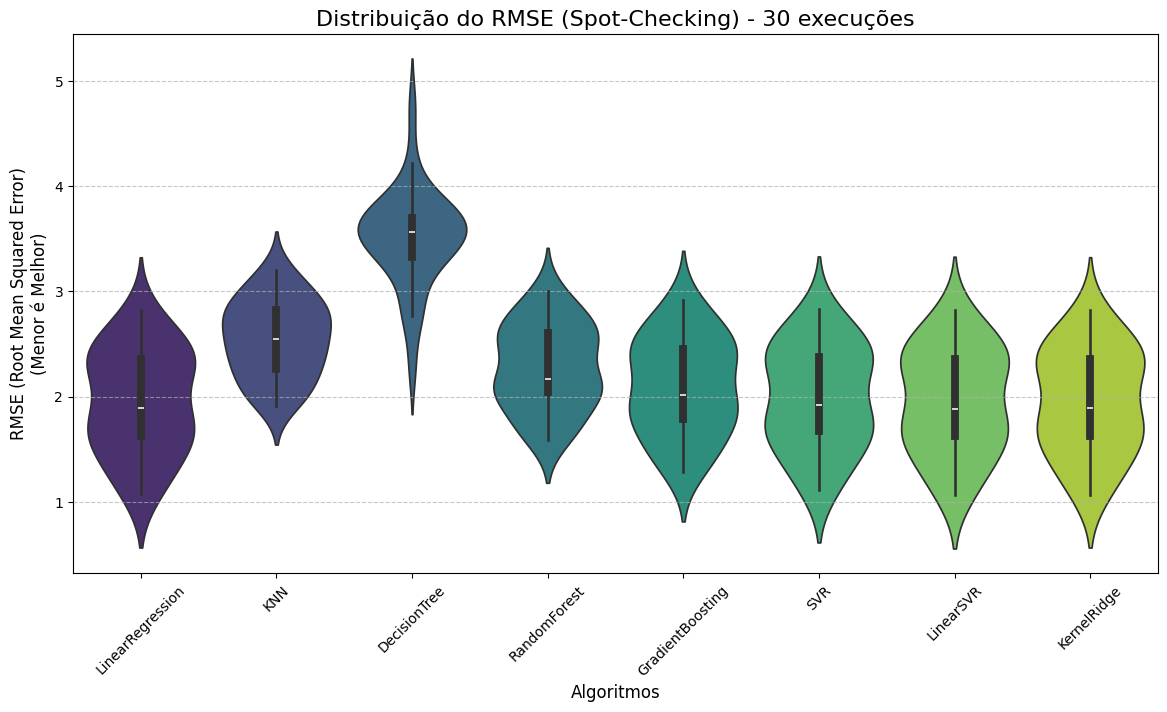


Gráfico de Box Plot (Comparação R²)


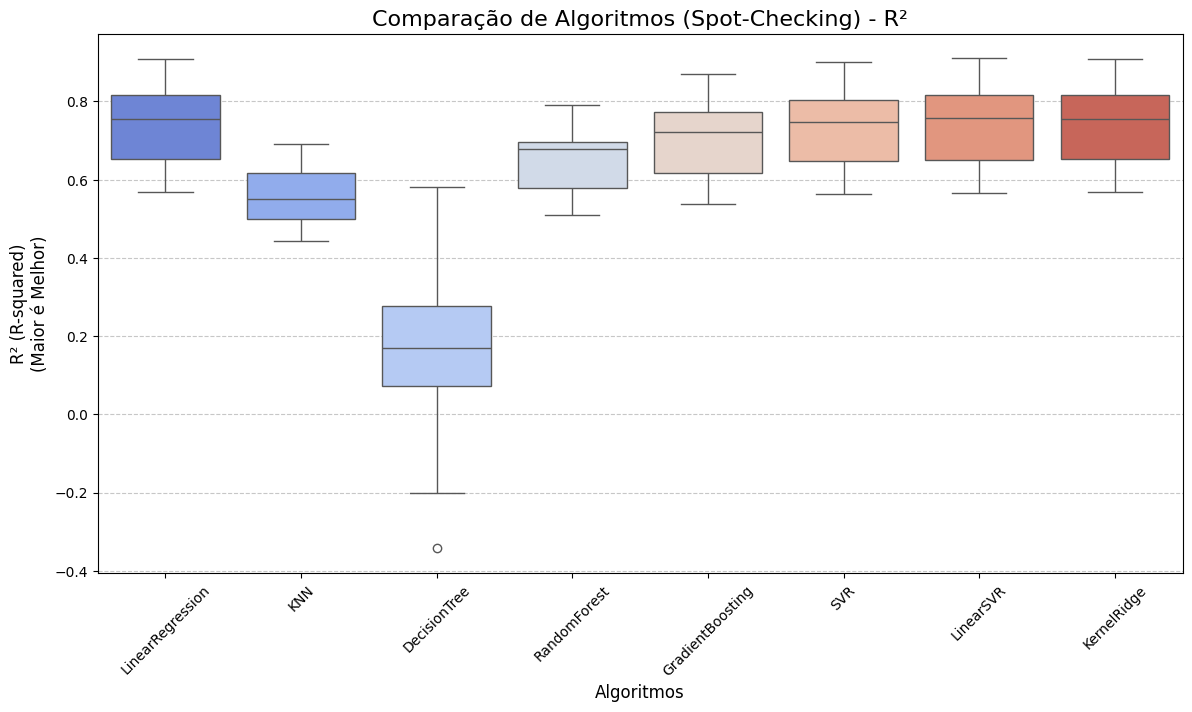

In [ ]:
#@title Sumarização dos Resultados
if 'results_rmse' in locals() and results_rmse:
    summary_data = []
    for i, name in enumerate(model_names):
        summary_data.append({
            'Model': name,
            'RMSE (Média)': np.mean(results_rmse[i]),
            'RMSE (Std)': np.std(results_rmse[i]),
            'R² (Média)': np.mean(results_r2[i]),
            'R² (Std)': np.std(results_r2[i]),
        })
    summary_df = pd.DataFrame(summary_data).sort_values(by='RMSE (Média)', ascending=True)

    print("\nTabela de Desempenho (Média e Desvio Padrão)")
    print(summary_df.to_string(index=False, float_format="%.4f"))

    plot_data_rmse = []
    for i, name in enumerate(model_names):
        for score in results_rmse[i]:
            plot_data_rmse.append({'Model': name, 'RMSE': score})
    df_long_rmse = pd.DataFrame(plot_data_rmse)

    print("Gráfico de Violino (Distribuição do RMSE)")
    plt.figure(figsize=(14, 7))
    sns.violinplot(
        data=df_long_rmse,
        x='Model',
        y='RMSE',
        inner='box', # Adiciona um mini-box plot dentro do violino
        palette='viridis',
        hue='Model', # Adicionado para resolver FutureWarning
        legend=False # Adicionado para resolver FutureWarning
    )
    plt.title(f'Distribuição do RMSE (Spot-Checking) - {N_SPLITS*N_REPEATS} execuções', fontsize=16)
    plt.ylabel('RMSE (Root Mean Squared Error)\n(Menor é Melhor)', fontsize=12)
    plt.xlabel('Algoritmos', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plot_data_r2 = []
    for i, name in enumerate(model_names):
        for score in results_r2[i]:
            plot_data_r2.append({'Model': name, 'R2': score})
    df_long_r2 = pd.DataFrame(plot_data_r2)

    print("\nGráfico de Box Plot (Comparação R²)")
    # Box plot para a Métrica Secundária (R²)
    plt.figure(figsize=(14, 7))
    sns.boxplot(
        data=df_long_r2,
        x='Model',
        y='R2',
        palette='coolwarm',
        hue='Model', # Adicionado para resolver FutureWarning
        legend=False # Adicionado para resolver FutureWarning
    )
    plt.title(f'Comparação de Algoritmos (Spot-Checking) - R²', fontsize=16)
    plt.ylabel('R² (R-squared)\n(Maior é Melhor)', fontsize=12)
    plt.xlabel('Algoritmos', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    """# Visualização Gráfica (Box Plot) para a Métrica Principal (RMSE)
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_long_rmse, x='Model', y='RMSE', hue='Model', legend=False) # Changed to use df_long_rmse and added hue/legend
    plt.title(f'Comparação de Algoritmos (Spot-Checking) - {N_SPLITS}-Fold CV', fontsize=16)
    plt.ylabel('RMSE (Root Mean Squared Error)\n(Menor é Melhor)', fontsize=12)
    plt.xlabel('Algoritmos', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Visualização Gráfica (Box Plot) para a Métrica Secundária (R²)
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_long_r2, x='Model', y='R2', hue='Model', legend=False) # Changed to use df_long_r2 and added hue/legend
    plt.title(f'Comparação de Algoritmos (Spot-Checking) - {N_SPLITS}-Fold CV', fontsize=16)
    plt.ylabel('R² (R-squared)\n(Maior é Melhor)', fontsize=12)
    plt.xlabel('Algoritmos', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()"""


No caso, podemos ver que os modelos mais simples estão superando os modelos *ensemble*, sugerindo que as relações entre as *features* e o alvo são **predominantemente lineares** e um modelo complexo não parece ser necessário. É importante ressaltar que o SVR padrão é não-linear, mas o fato do seu desempenho estar tão próximo da Regressão Linear sugere que ele está operando de forma muito similar.

O péssimo desempenho da Árvore de Decisão (única, sem poda - configuração padrão) é decorrente do *overfitting* nos dados de treino de cada *fold*. Já os modelos RandomForest e GradientBoosting provavelmente são complexos demais para este *dataset* com hiperparâmetros padrão.

Em uma investigação mais detalhada, configurações extra e otimização de modelos poderia ser utilizada para reduzir a complexidade e evitar o *overfitting*. O melhor candidato para isso é o GradientBoosting.

Próximos passos: Poderíamos adicionar dois algoritmos que poderiam se destacar:
*   Ridge (Regressão Linear com Regularização L2): Versão regularizada da Regressão Linear, que pode lidar melhor com multicolinearidade, se houver.
*   SVR Linear: utilizando um kernel linear para comparar se daria um resultado idêntico à Regressão Linear.